In [15]:
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from tqdm import tqdm
from functools import reduce
import matplotlib.pyplot as plt
import time
import scipy

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 4.0)
ctx = mx.gpu(0)

In [16]:
from rnn_utils import fourier_features, RNNModel, detach, generate_weight_sample

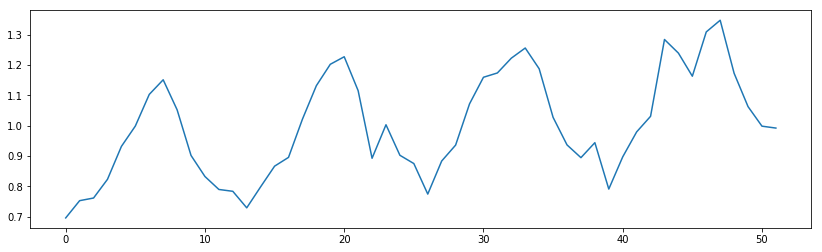

In [17]:
df = pd.read_csv("fourweekly-totals-of-beer-shipme.csv", header=0)
ts = df.values[:,1]
ts = ts/np.mean(ts)
plt.plot(ts);

In [22]:
num_feat=1
#num_hidden=1
num_layer=1
num_epochs=2000
f_horizon=50

Use last the lag-1 demand as features ...

In [23]:
xff = nd.array(ts[:-1]).as_in_context(ctx).reshape(shape=(51,1,1))
yff = nd.array(ts[1:]).as_in_context(ctx).reshape(shape=(1,51))

In [31]:
def rnn_forecast(num_hidden=1, rnn="lstm"):
    model = RNNModel("lstm", num_feat, num_hidden, num_layer)
    model.hybridize()
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})
    l2loss = gluon.loss.L2Loss()

    for e in range(num_epochs):
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = 1, ctx=ctx)
        hidden = detach(hidden)
        with autograd.record():
            output, hidden = model(xff, hidden)
            L = l2loss(output.T, yff)
            L.backward()
        trainer.step(1)

    xt = nd.array([ts[-1]]).as_in_context(ctx).reshape((1,1,1))
    fcst=[]
    for i in range(f_horizon):
        yt, hidden = model(xt, hidden)
        fcst.append(yt.reshape((-1,)).asnumpy()[0])
        xt = yt.reshape((1,1,1))
    plt.figure()
    plt.plot(np.arange(1, len(ts)+f_horizon), np.array(list(output.reshape((-1,)).asnumpy())+fcst), 'r--'); 
    plt.plot(ts); 
    plt.title("RNN type: %s with num_hidden = %d" % (rnn, num_hidden))
    plt.grid()

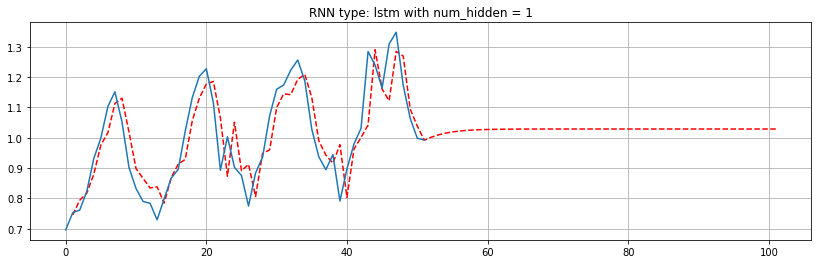

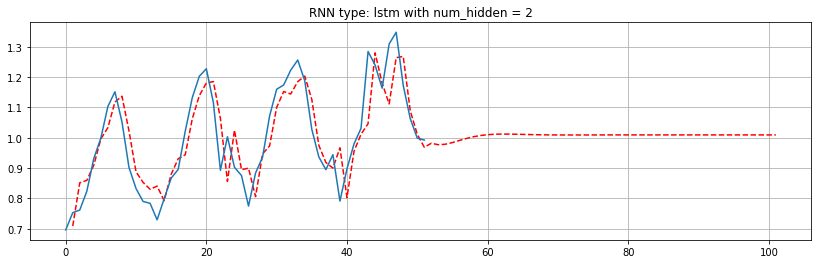

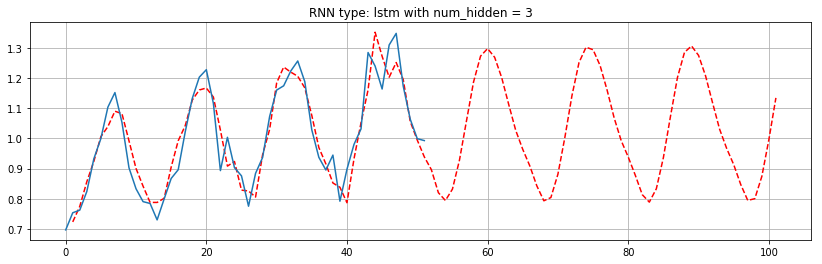

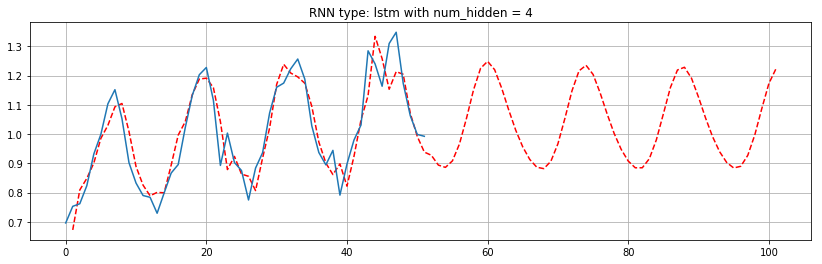

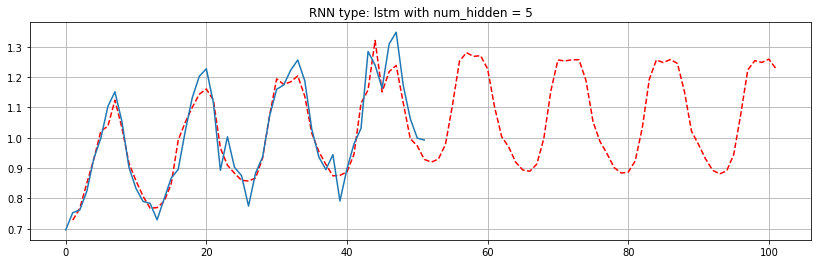

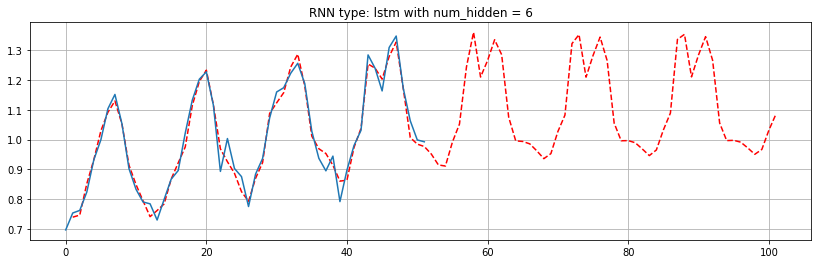

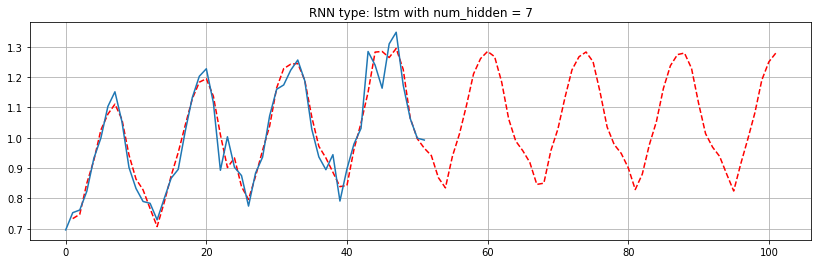

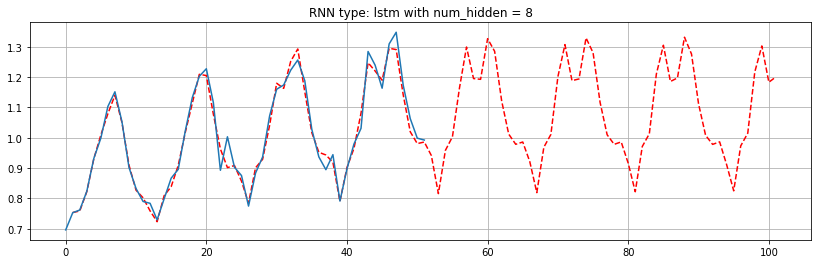

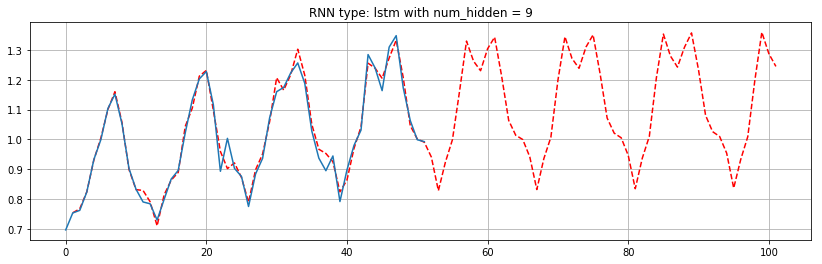

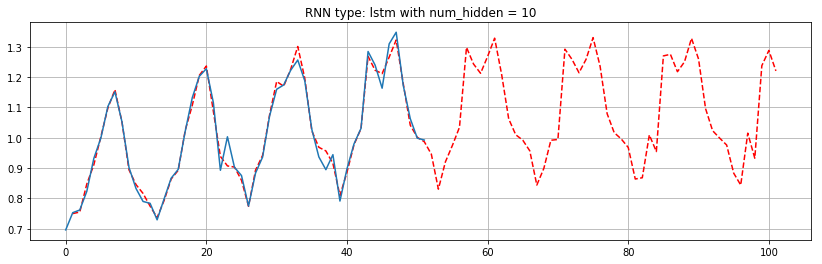

In [32]:
for num_hidden in range(1, 11):
    rnn_forecast(num_hidden, 'lstm')

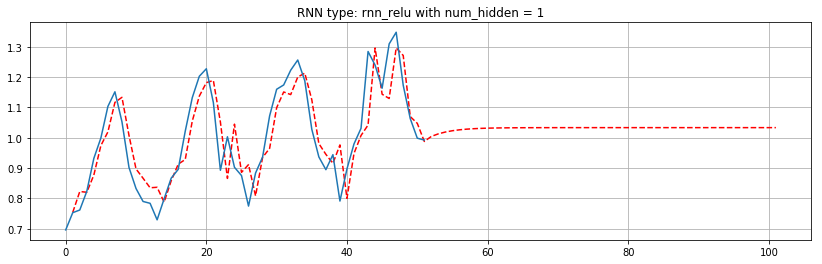

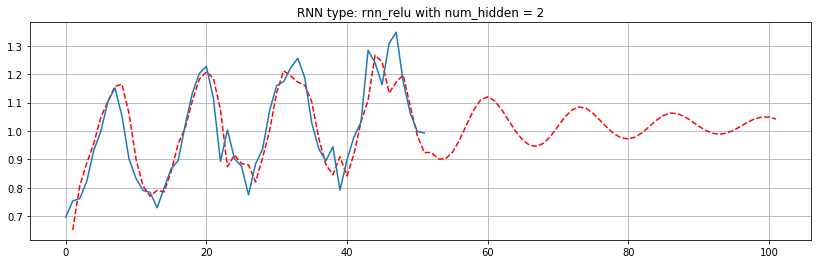

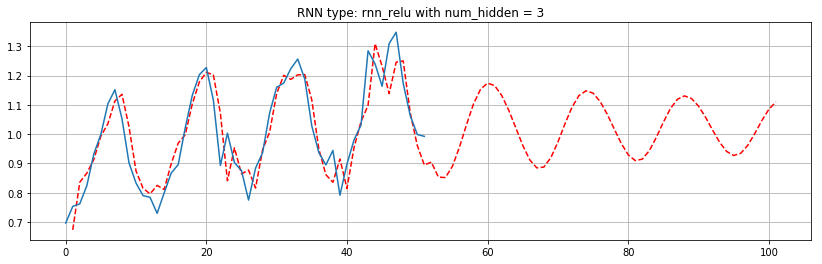

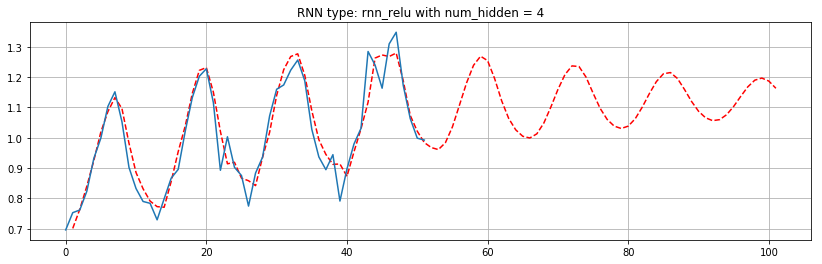

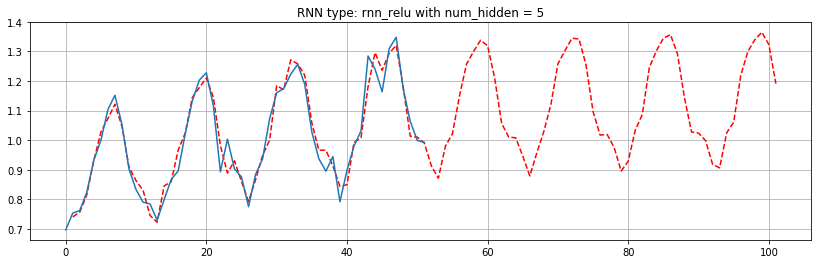

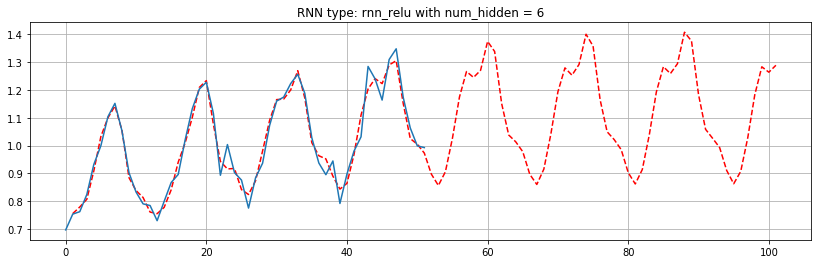

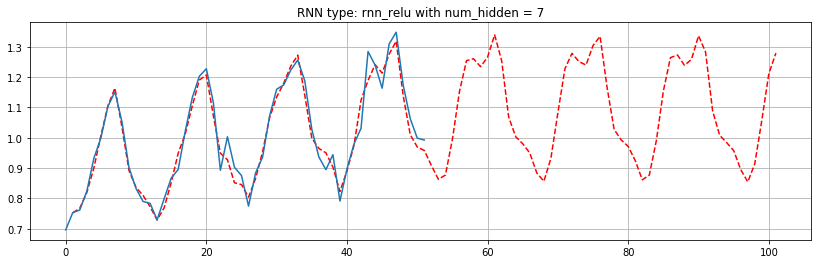

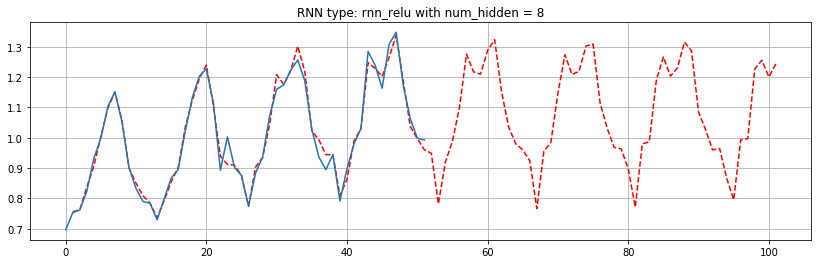

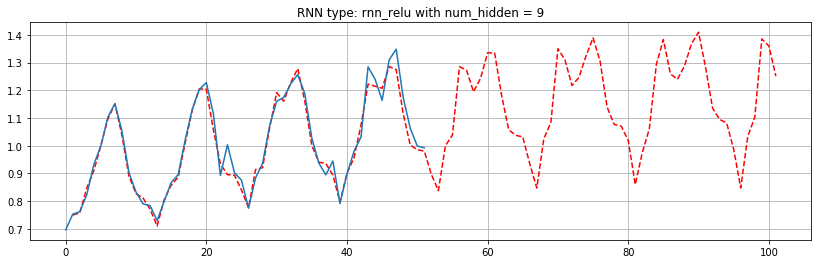

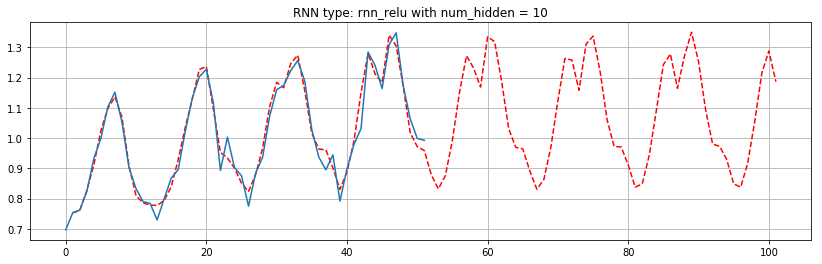

In [33]:
for num_hidden in range(1, 11):
    rnn_forecast(num_hidden, 'rnn_relu')

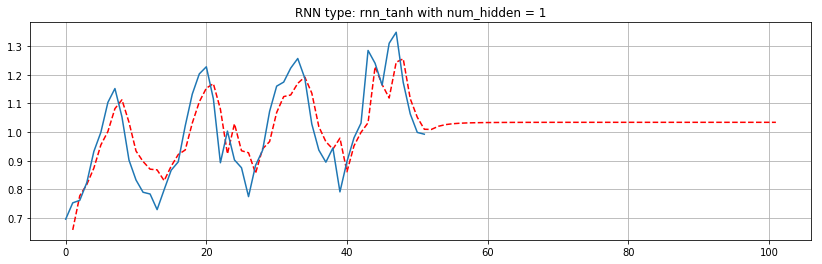

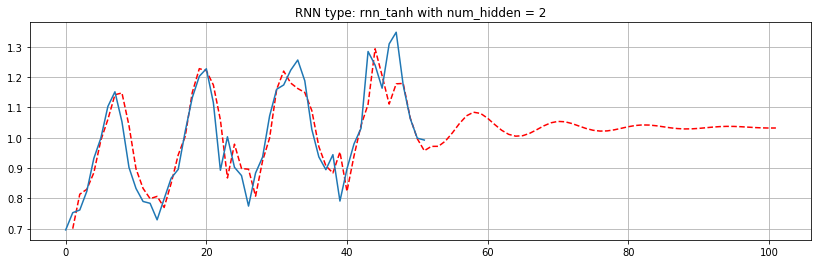

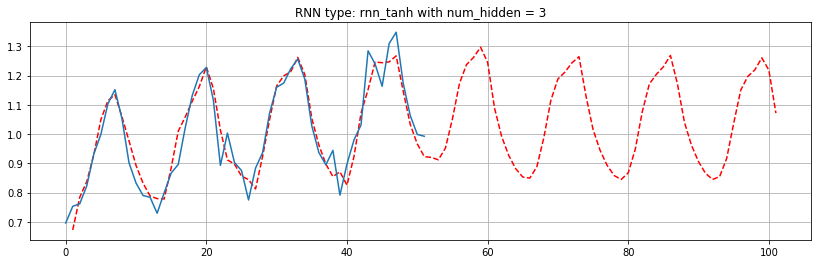

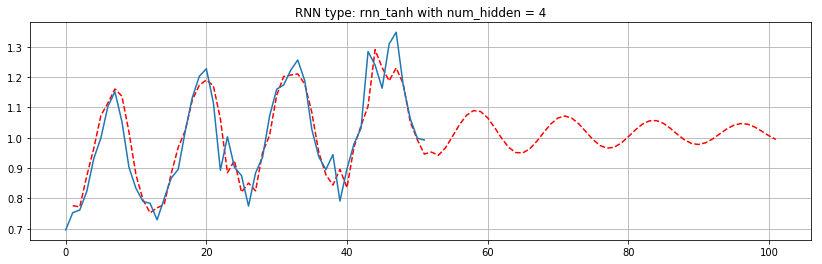

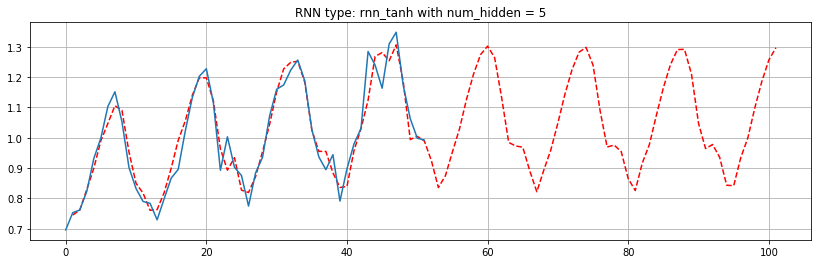

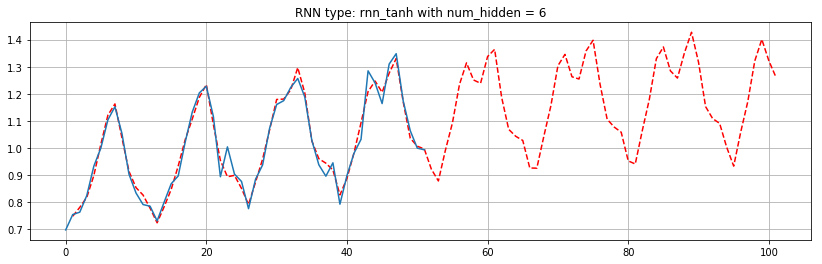

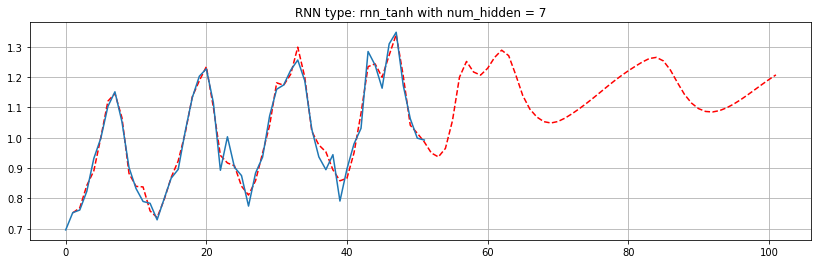

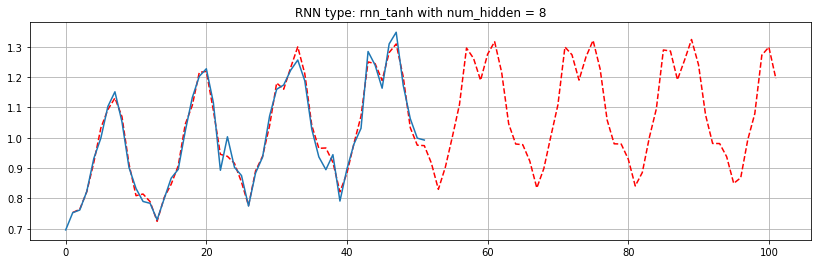

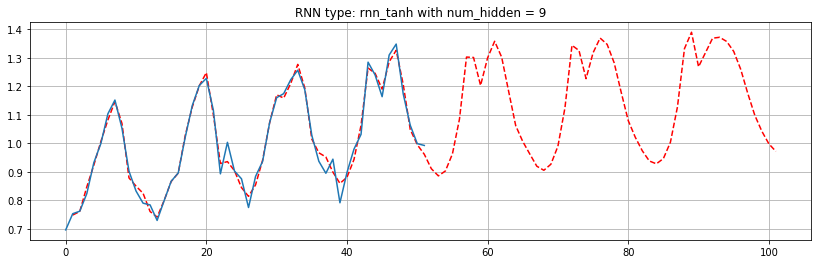

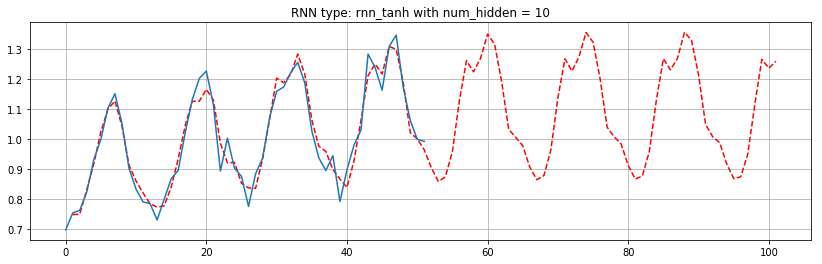

In [34]:
for num_hidden in range(1, 11):
    rnn_forecast(num_hidden, 'rnn_tanh')

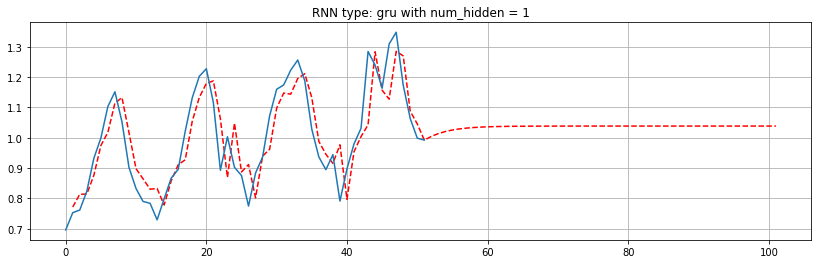

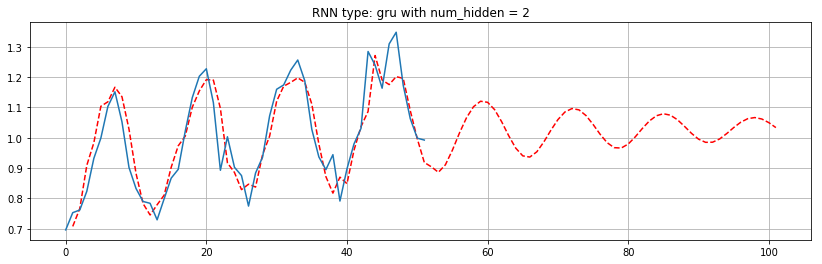

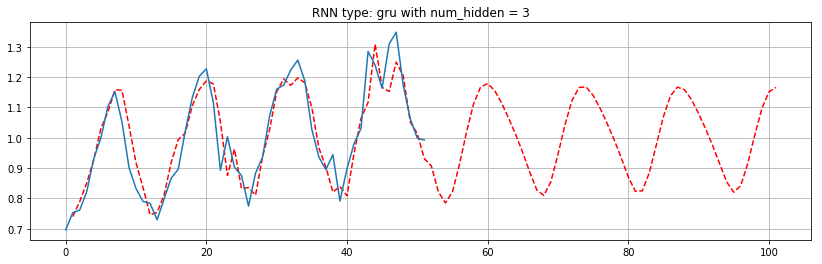

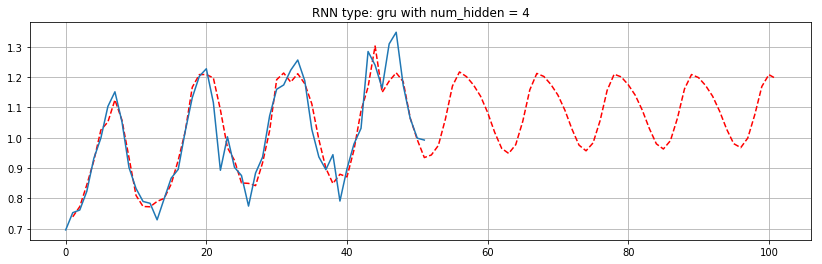

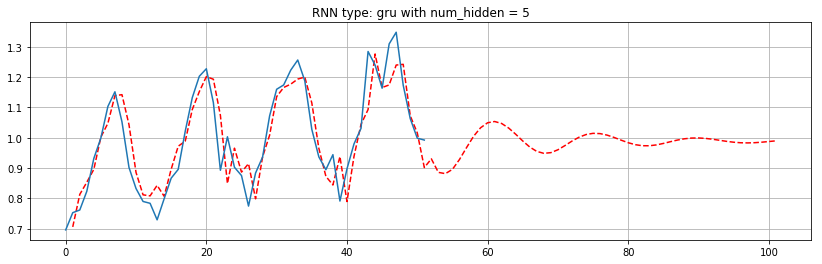

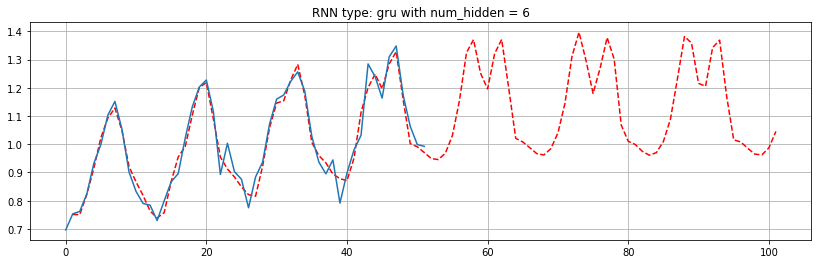

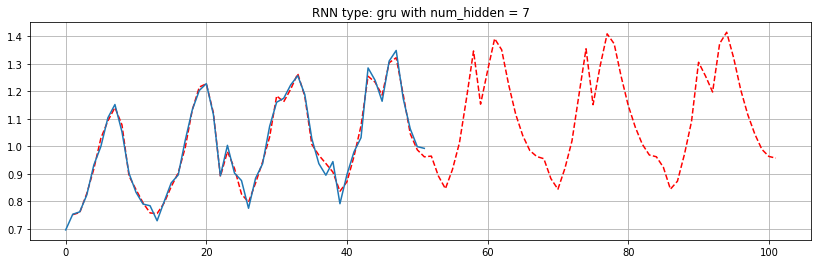

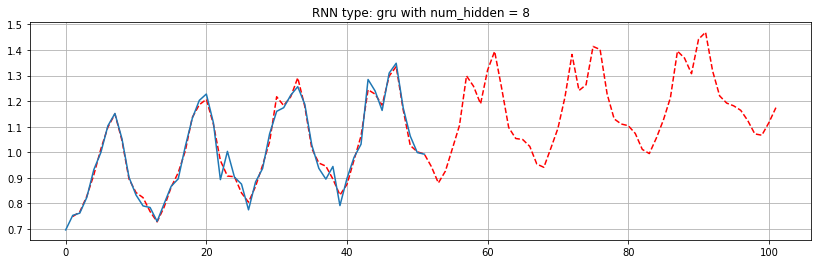

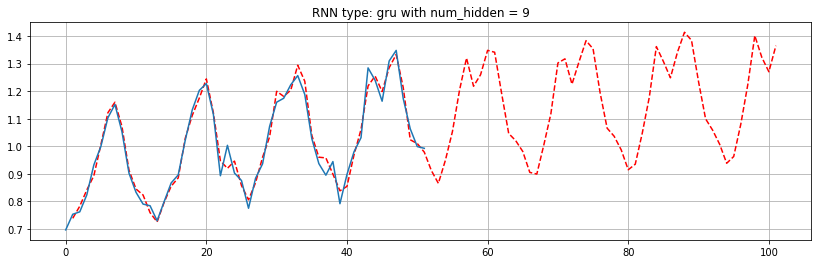

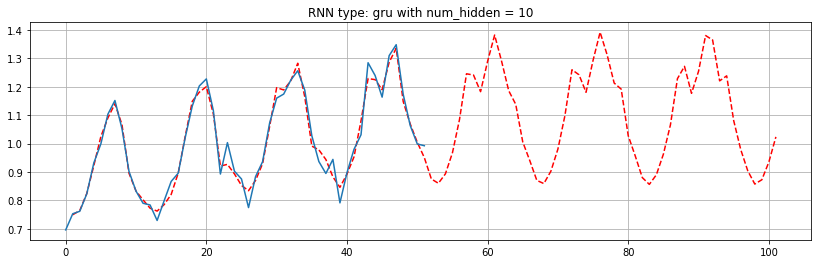

In [35]:
for num_hidden in range(1, 11):
    rnn_forecast(num_hidden, 'gru')